imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish/"
experimentName="Fish30-5run-PhyloNN6"#"Fish-L1-experiment2"#"CIFAR_phylogeny_HGNN_lambdaExperiment"
# trial_hash="27a4da8bf0c3bca7096cddf192ecf3069e035ad3fbba69bbd47bd157" #MSE + L1
#"5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186"#hier
trial_hash="0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4" #PhyloNN
SEED_INT=4 # order of the trial_hash when executed

legends=['fine', 'coarse']
use_submodel=False
dataset_name="test"
cuda=0
batch_size = 4
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 0


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experiment_params = config_parser.fixExperimentParams(experiment_params)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders(SEED_INT)

dataloader = torch.utils.data.DataLoader(test_loader.dataset if dataset_name=="test" else train_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
dataset = dataloader.dataset

{'experimentName': 'Fish30-5run-PhyloNN6', 'modelName': 'models/0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'datasetName': 'datasplits/a30fade0855f8d4a9e28fdac4e65ae71ab21444a323ee6e3927d97f8', 'experimentHash': '2f4afd9af84811c61585f52e9e69fb2b8fc8e83ae71fa846e602b672', 'trialHash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'image_path': 'Curated4/Easy_30', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.001, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'PhyloNN', 'lambda': 1.0, 'unsupervisedOnTest': None, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'noSpeciesBackprop': False, 'phylogeny_loss': 'False', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': False, 'tripletSamples': 2.0, 'tripletSelector': 'semihard', 'tripletMargin': 2.0, 'displayName': 'Fish30-5run-PhyloNN-smalldistances-intraKorthogonality', 'pretrained': True, 'epochs

Get untrained model

In [5]:
%%capture

# architecture = {
#     "fine": len(dataset.csv_processor.getFineList()),
#     "coarse" : len(dataset.csv_processor.getCoarseList())
# }
architecture = CNN.get_architecture(experiment_params, train_loader.dataset.csv_processor)
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Show example and closest images

Show TSNE

100%|██████████| 57/57 [00:03<00:00, 17.65it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.002s...
[t-SNE] Computed neighbors for 228 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 3.667844
[t-SNE] Computed conditional probabilities in 0.015s
[t-SNE] Iteration 50: error = 50.5287590, gradient norm = 0.5820835 (50 iterations in 0.048s)
[t-SNE] Iteration 100: error = 48.0618935, gradient norm = 0.5801916 (50 iterations in 0.063s)
[t-SNE] Iteration 150: error = 47.6965370, gradient norm = 0.5876662 (50 iterations in 0.076s)
[t-SNE] Iteration 200: error = 45.9776611, gradient norm = 0.6123393 (50 iterations in 0.081s)
[t-SNE] Iteration 250: error = 47.0988503, gradient norm = 0.5789688 (50 iterations in 0.090s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.098850
[t-SNE] Iteration 300: error = 0.0994980, gradient norm = 0.0034578 (50 iterations in 0.115s)
[t-SNE] Iteration 350: error = 0.0867264, gradient norm = 0.0005558 (

100%|██████████| 57/57 [00:03<00:00, 15.28it/s]


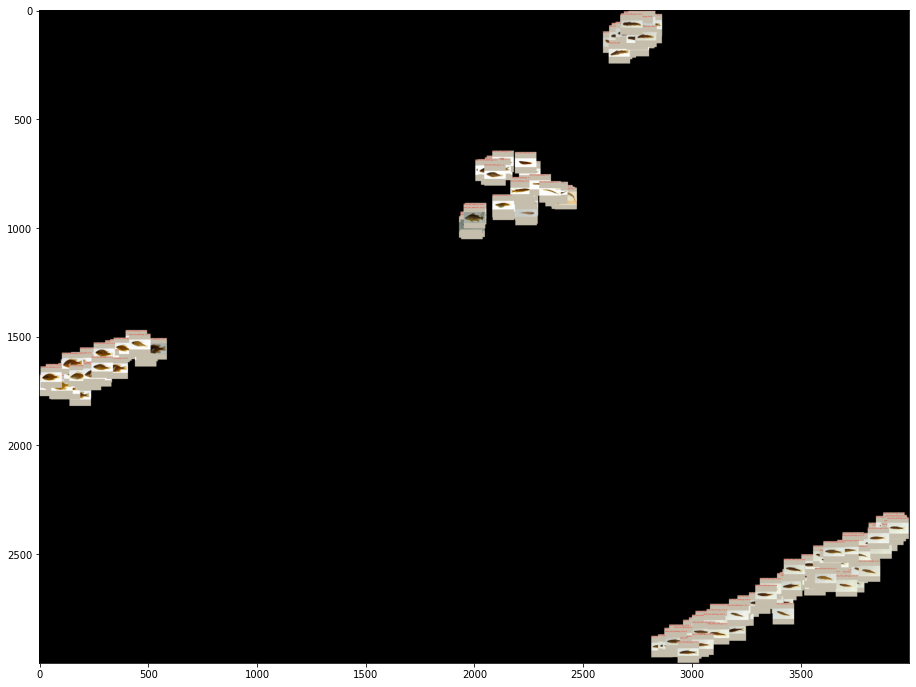

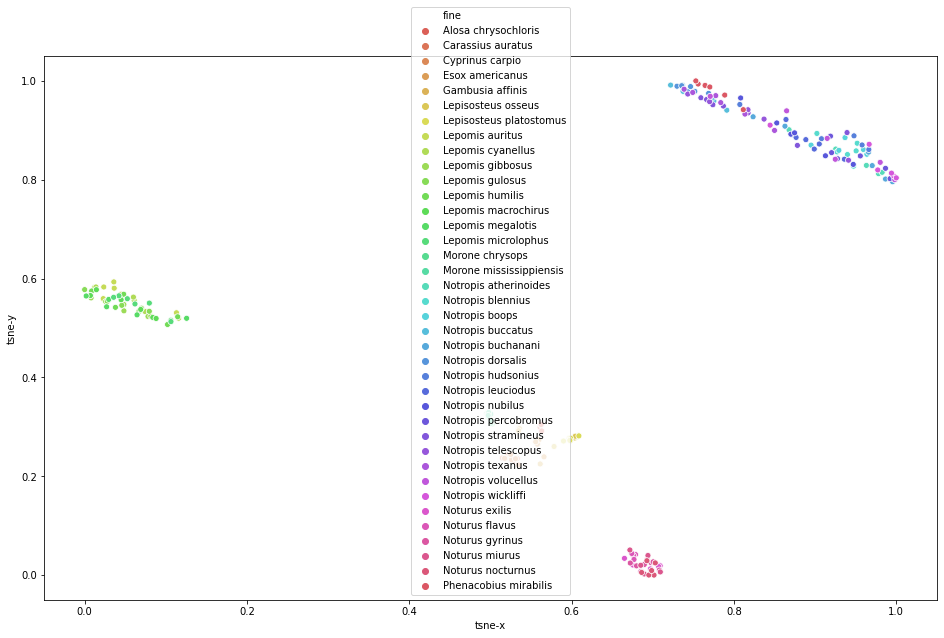

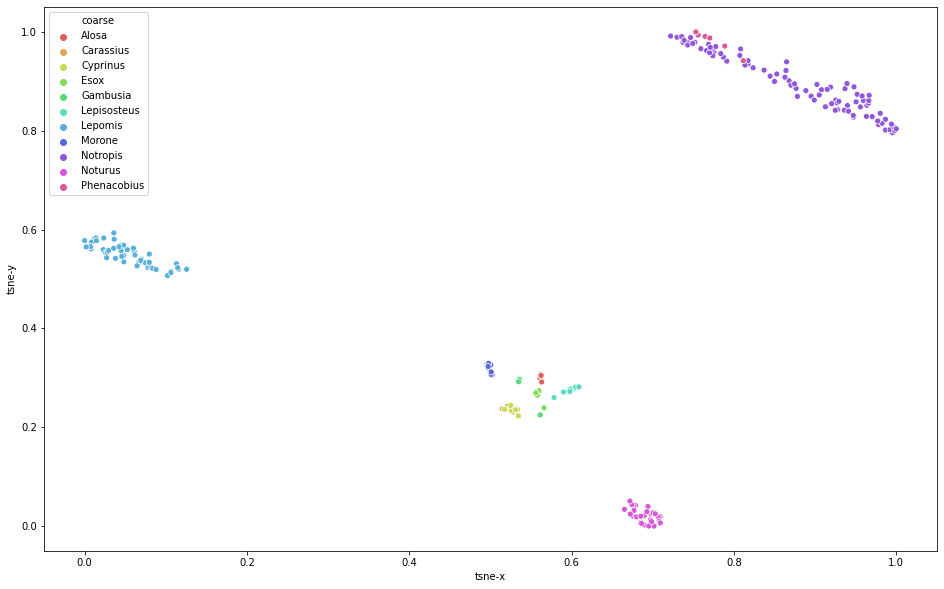

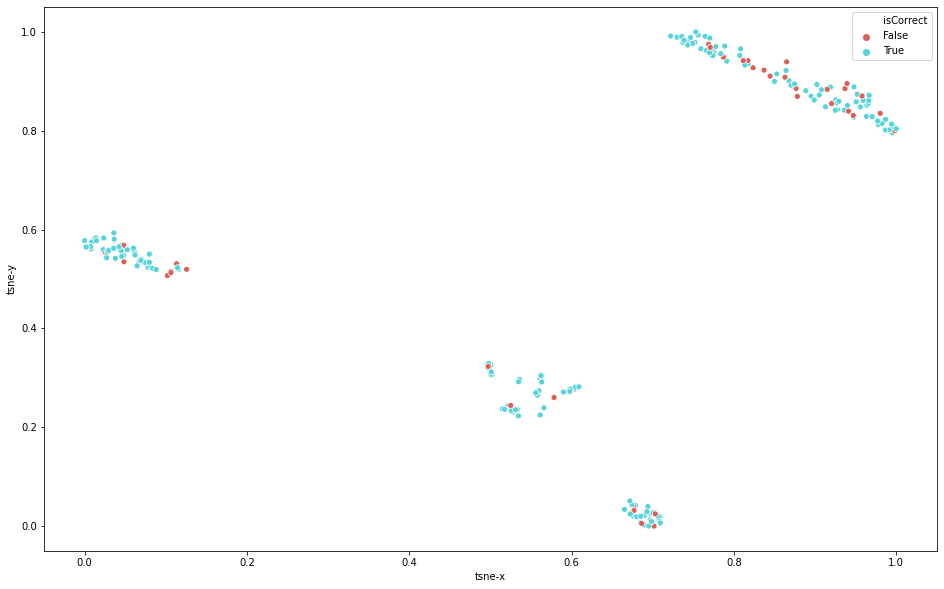

In [6]:
# activation_layer = 'layer2'#'fine'
activation_layer ='01distance'

model_sub = model
if hasattr(model, 'network_fine') and use_submodel==True:
    model_sub = model.network_fine

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 57/57 [00:03<00:00, 15.39it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.001s...
[t-SNE] Computed neighbors for 228 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 2.615209
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 50.6517944, gradient norm = 0.5961203 (50 iterations in 0.061s)
[t-SNE] Iteration 100: error = 48.7952003, gradient norm = 0.5705036 (50 iterations in 0.057s)
[t-SNE] Iteration 150: error = 47.9768639, gradient norm = 0.5977720 (50 iterations in 0.064s)
[t-SNE] Iteration 200: error = 47.1766243, gradient norm = 0.6342664 (50 iterations in 0.068s)
[t-SNE] Iteration 250: error = 47.1926918, gradient norm = 0.6303644 (50 iterations in 0.068s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.192692
[t-SNE] Iteration 300: error = 0.1425644, gradient norm = 0.0023412 (50 iterations in 0.077s)
[t-SNE] Iteration 350: error = 0.1298714, gradient norm = 0.0005059 (

100%|██████████| 57/57 [00:03<00:00, 15.75it/s]


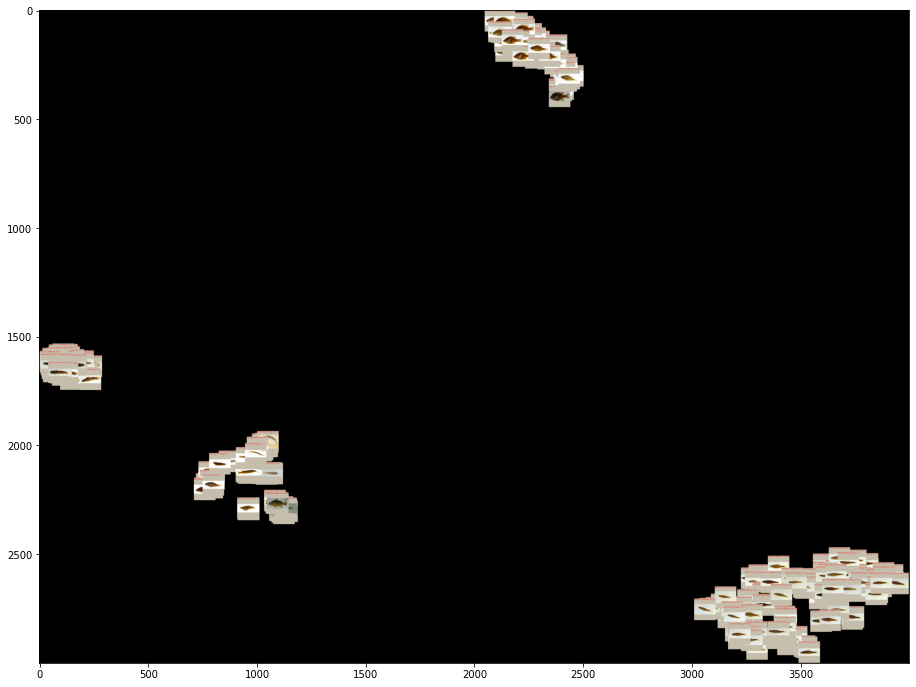

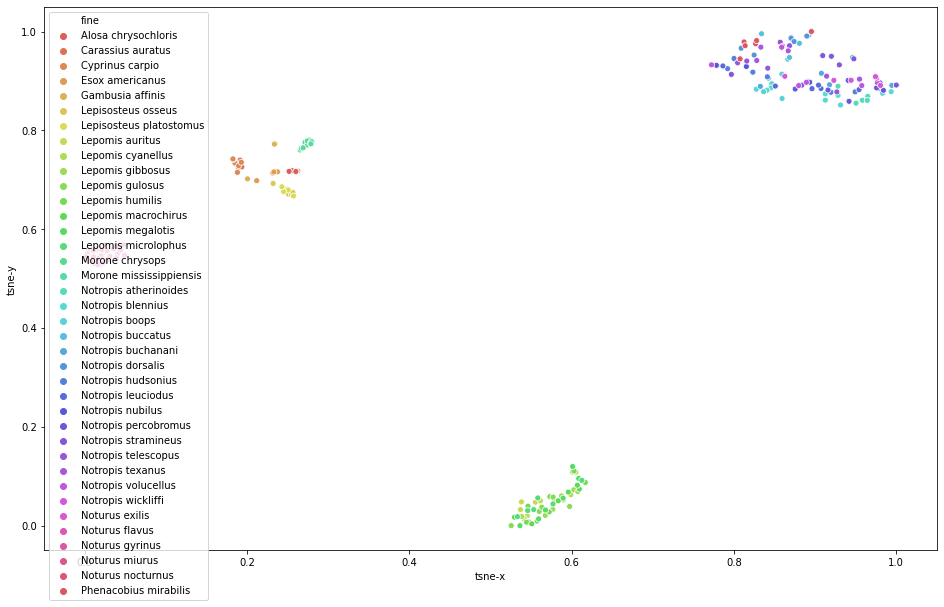

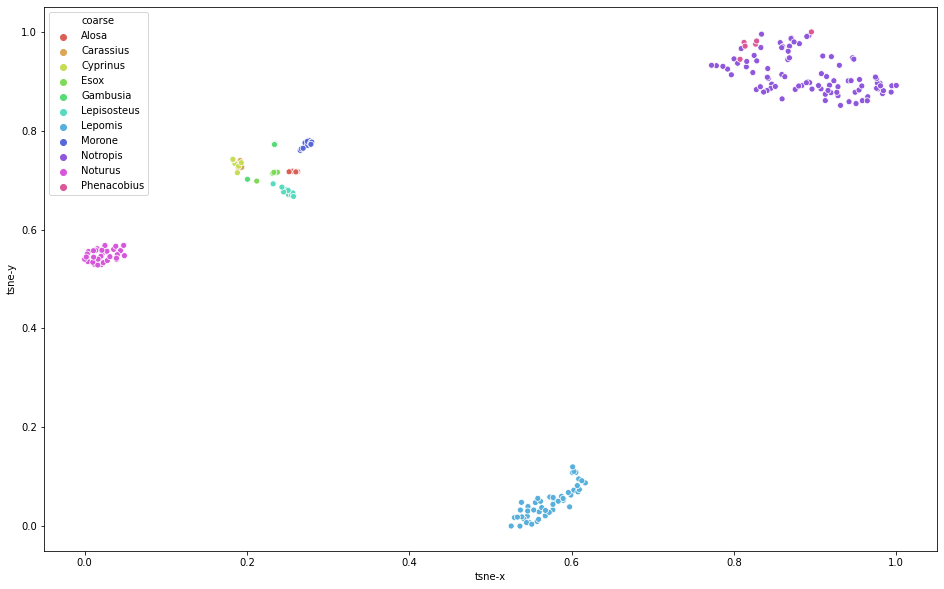

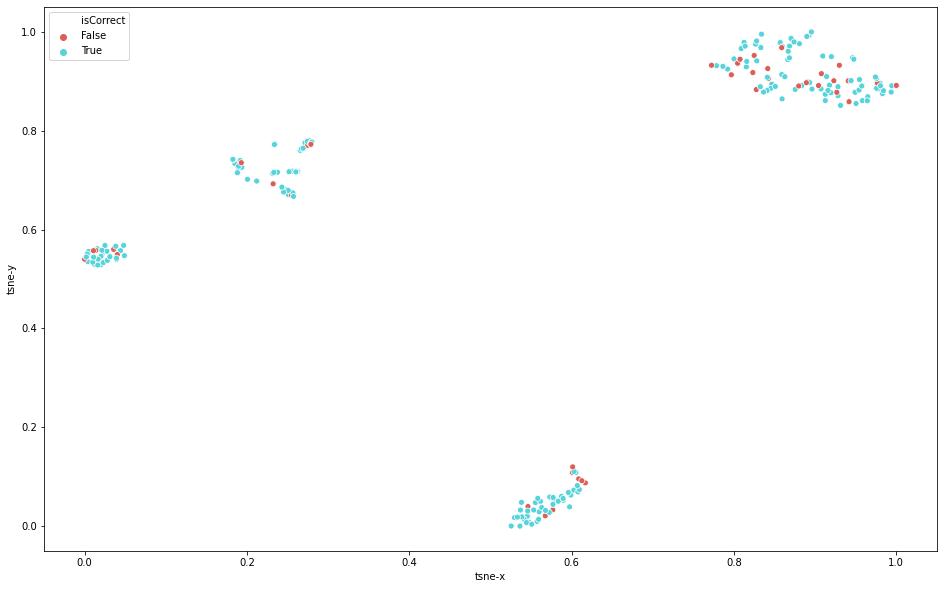

In [7]:
# activation_layer = 'layer4'#'fine'
activation_layer ='03distance'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 57/57 [00:03<00:00, 16.23it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.001s...
[t-SNE] Computed neighbors for 228 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 2.607727
[t-SNE] Computed conditional probabilities in 0.014s
[t-SNE] Iteration 50: error = 50.5599022, gradient norm = 0.6274043 (50 iterations in 0.074s)
[t-SNE] Iteration 100: error = 49.8787003, gradient norm = 0.5697322 (50 iterations in 0.053s)
[t-SNE] Iteration 150: error = 50.5635414, gradient norm = 0.5480580 (50 iterations in 0.053s)
[t-SNE] Iteration 200: error = 51.2174644, gradient norm = 0.5580636 (50 iterations in 0.062s)
[t-SNE] Iteration 250: error = 49.2364120, gradient norm = 0.6137387 (50 iterations in 0.056s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.236412
[t-SNE] Iteration 300: error = 0.1836264, gradient norm = 0.0025212 (50 iterations in 0.057s)
[t-SNE] Iteration 350: error = 0.1689781, gradient norm = 0.0005351 (

100%|██████████| 57/57 [00:03<00:00, 15.64it/s]


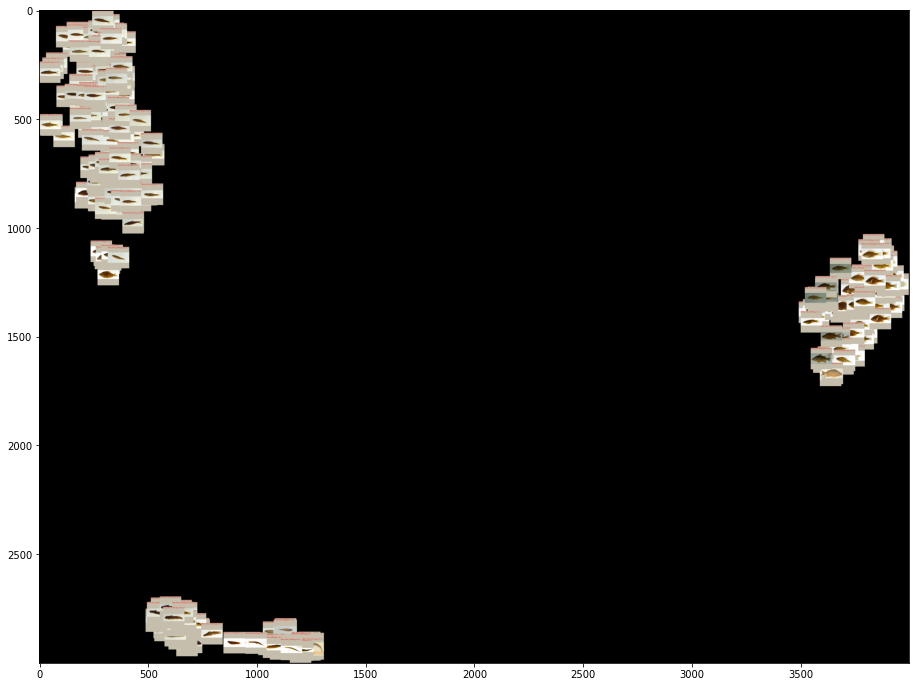

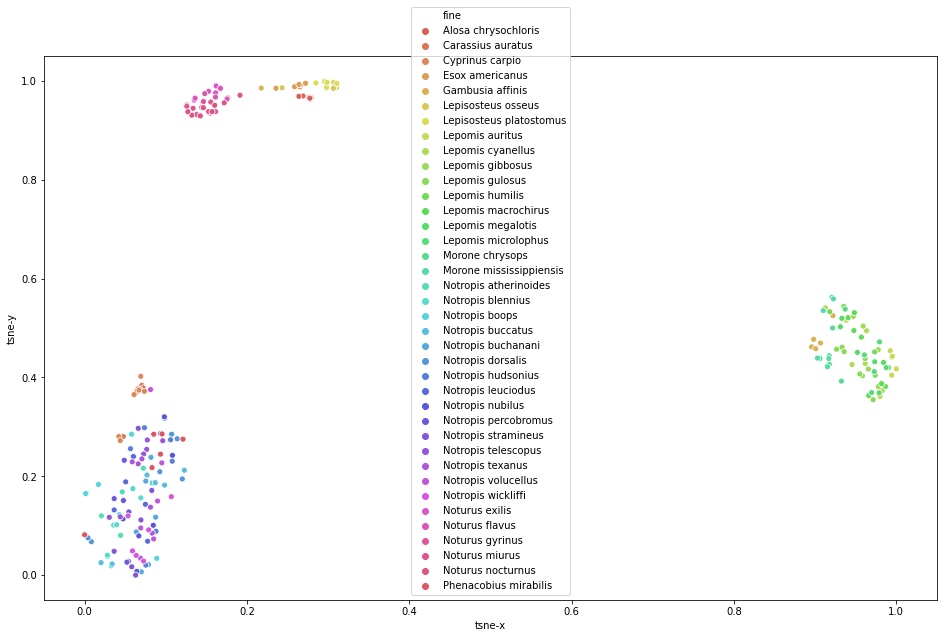

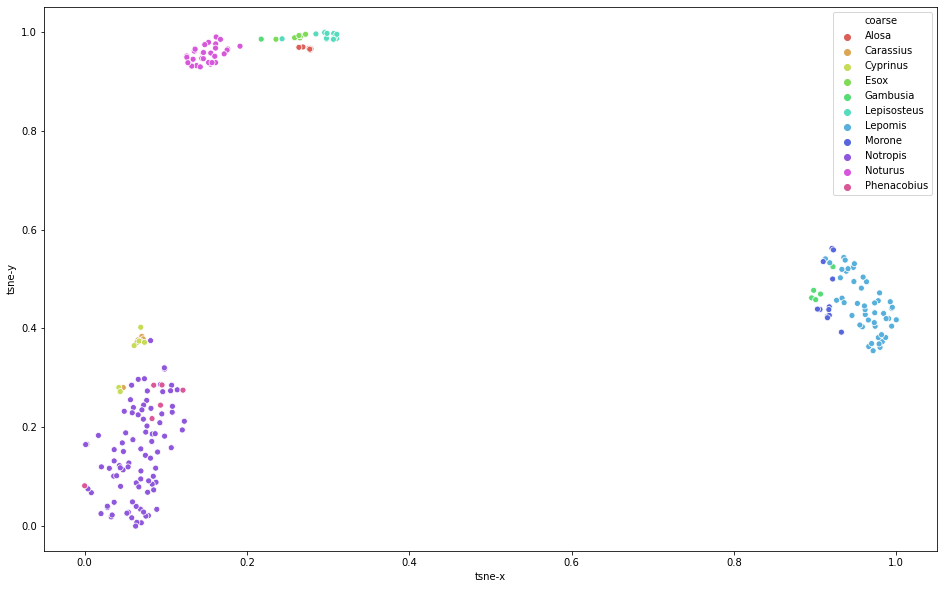

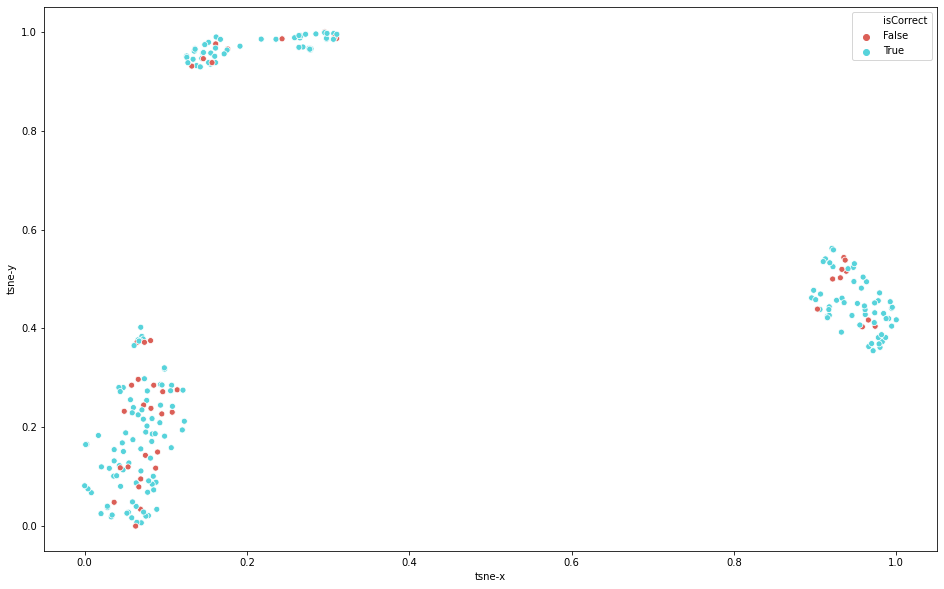

In [8]:
activation_layer ='05distance'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 57/57 [00:03<00:00, 15.70it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.002s...
[t-SNE] Computed neighbors for 228 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 5.931913
[t-SNE] Computed conditional probabilities in 0.013s
[t-SNE] Iteration 50: error = 54.5908852, gradient norm = 0.5811759 (50 iterations in 0.034s)
[t-SNE] Iteration 100: error = 52.6625175, gradient norm = 0.6270747 (50 iterations in 0.030s)
[t-SNE] Iteration 150: error = 54.0264359, gradient norm = 0.5750304 (50 iterations in 0.036s)
[t-SNE] Iteration 200: error = 54.2953491, gradient norm = 0.5471388 (50 iterations in 0.038s)
[t-SNE] Iteration 250: error = 54.1319313, gradient norm = 0.5891268 (50 iterations in 0.039s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.131931
[t-SNE] Iteration 300: error = 0.2349022, gradient norm = 0.0027144 (50 iterations in 0.047s)
[t-SNE] Iteration 350: error = 0.1931459, gradient norm = 0.0006587 (

100%|██████████| 57/57 [00:03<00:00, 16.78it/s]


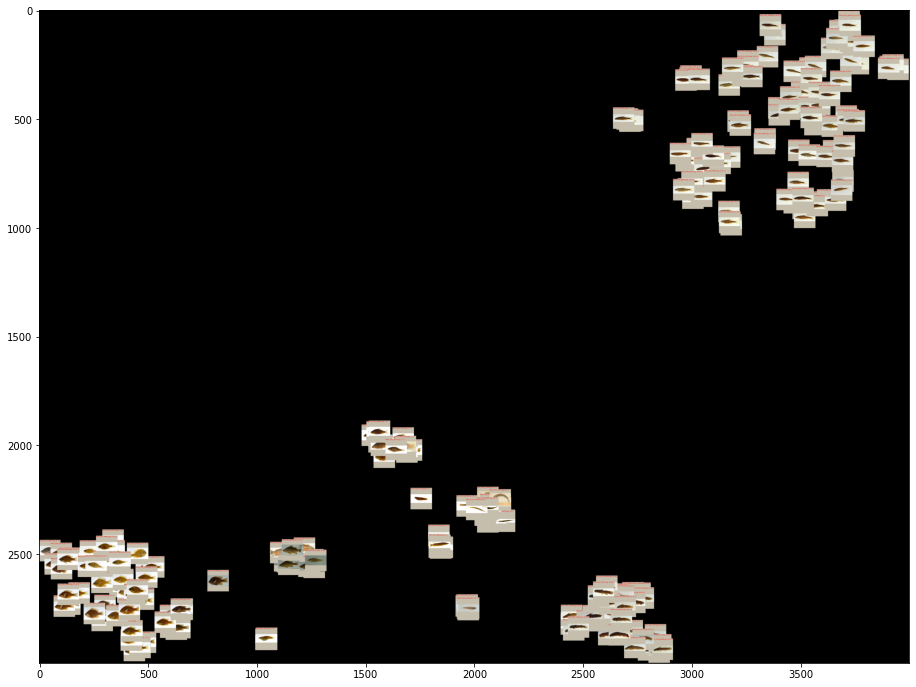

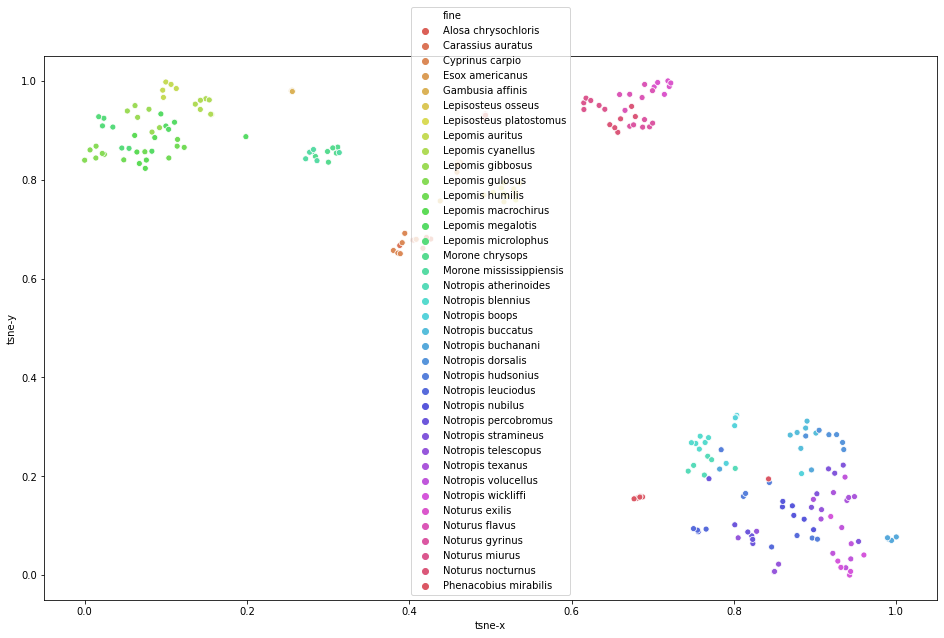

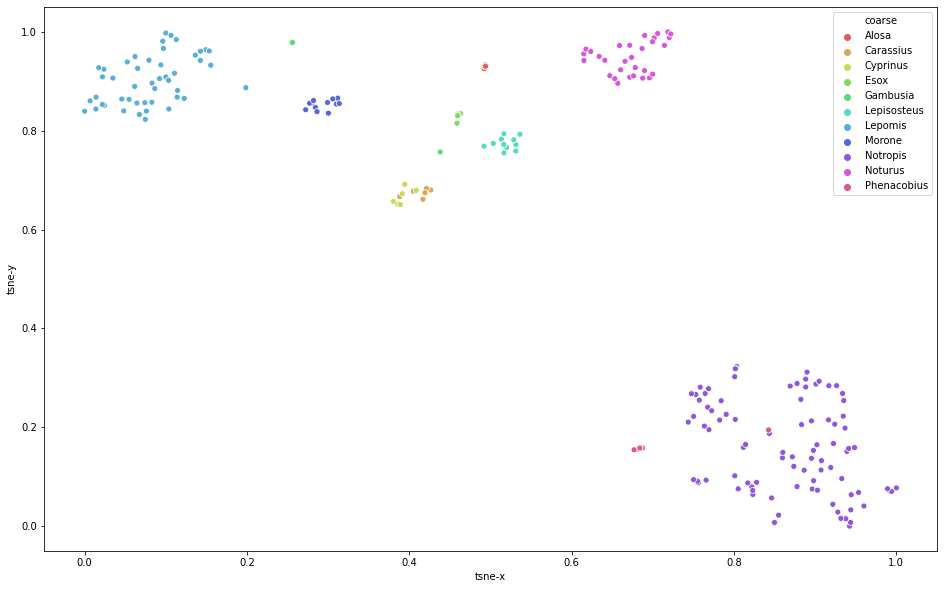

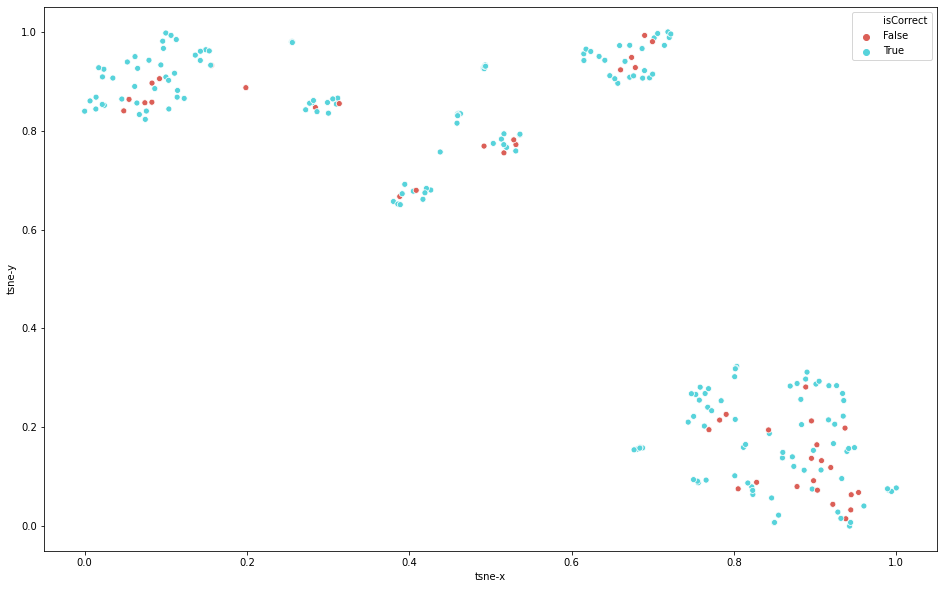

In [9]:
activation_layer = 'fine'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 57/57 [00:03<00:00, 16.26it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.002s...
[t-SNE] Computed neighbors for 228 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 8.674256
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 55.6812897, gradient norm = 0.6168527 (50 iterations in 0.148s)
[t-SNE] Iteration 100: error = 55.4489136, gradient norm = 0.5779888 (50 iterations in 0.105s)
[t-SNE] Iteration 150: error = 54.3975945, gradient norm = 0.5964859 (50 iterations in 0.110s)
[t-SNE] Iteration 200: error = 54.1302261, gradient norm = 0.5994956 (50 iterations in 0.105s)
[t-SNE] Iteration 250: error = 54.4121056, gradient norm = 0.6053451 (50 iterations in 0.104s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.412106
[t-SNE] Iteration 300: error = 0.2413745, gradient norm = 0.0019002 (50 iterations in 0.118s)
[t-SNE] Iteration 350: error = 0.2071462, gradient norm = 0.0007813 (

100%|██████████| 57/57 [00:03<00:00, 15.92it/s]


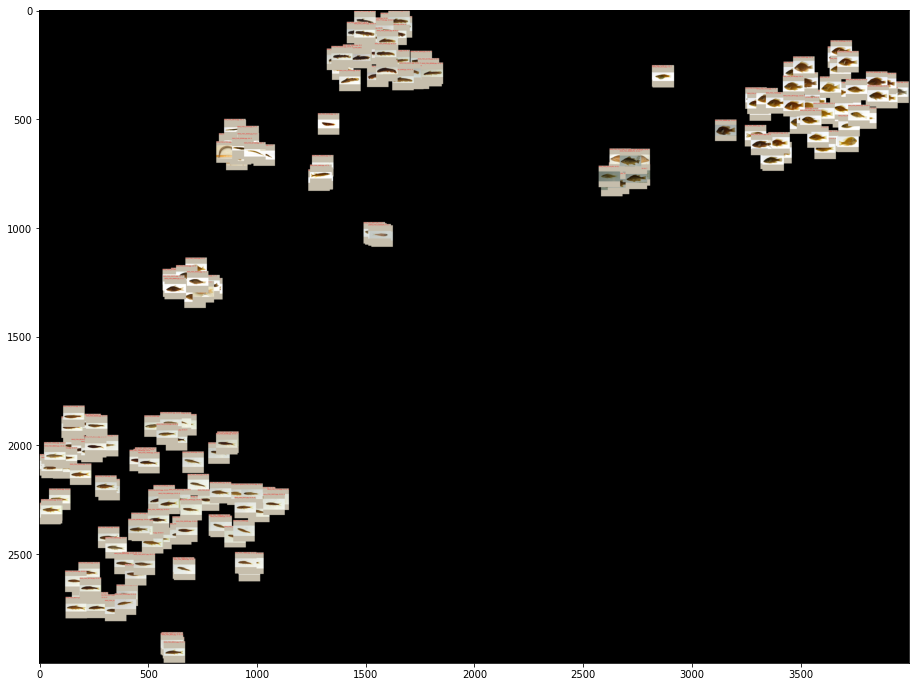

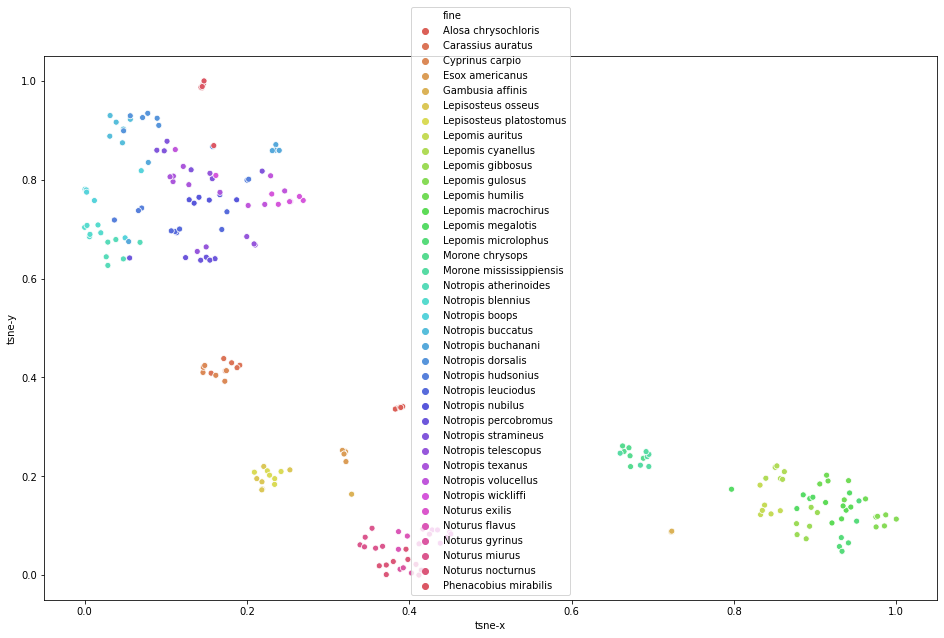

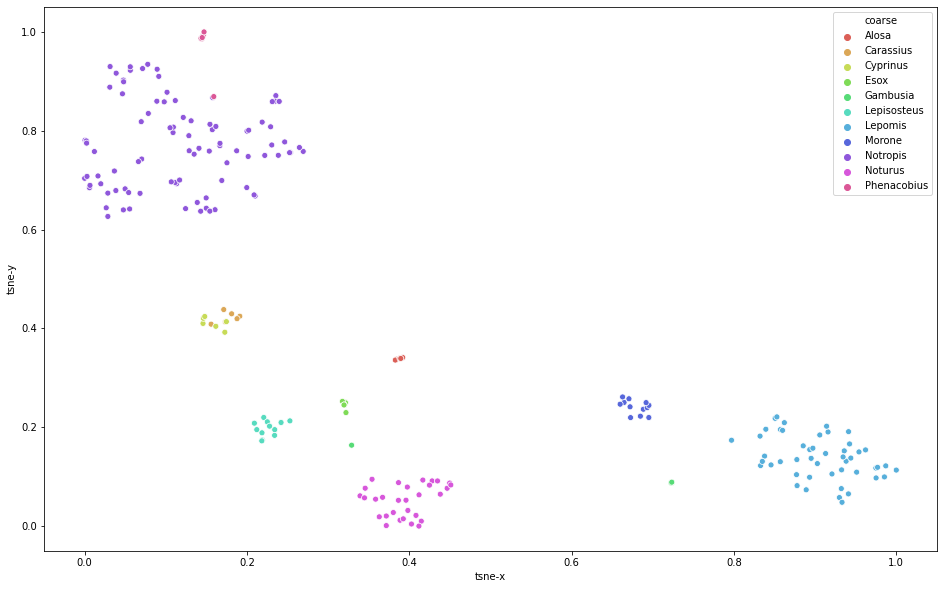

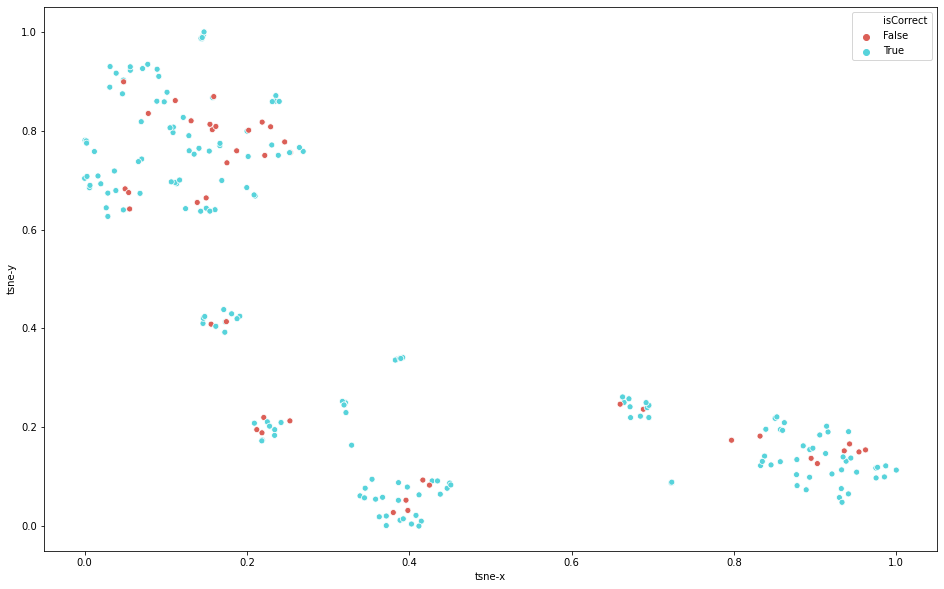

In [10]:
activation_layer = 'gap_features'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

In [41]:
#dict_keys(['input', 'gap_features', 'layer4_features', 'fine', '05distance', '03distance', '01distance'])
# activation_layer ='gap_features'
activation_layer ='fine'

X = None
Y= None
Z= None
a, n, _ = dataloader.dataset.toggle_image_loading(dataloader.dataset.augmentation_enabled, True)
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    image2 = batch['image'] 
    fine_label = batch['fine']
    if cuda is not None:
        image2 = image2.cuda()
    activations = model.activations(image2)
    features2 = activations[activation_layer].detach().cpu()
    features2 = features2.reshape(features2.shape[0], -1)
    pred, _ = CNN.getPredictions(activations['fine'], [])

    # Calculate distance for each pair.
    X = features2 if X is None else torch.cat([X, features2]).detach()
    Y = fine_label.tolist() if Y is None else Y + fine_label.tolist()
    Z = pred.tolist() if Z is None else Z + pred.tolist()
dataloader.dataset.toggle_image_loading(a, n)




100%|██████████| 57/57 [00:03<00:00, 16.77it/s]


(False, True, True)

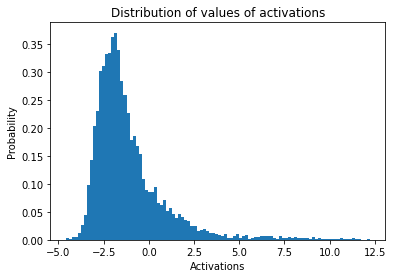

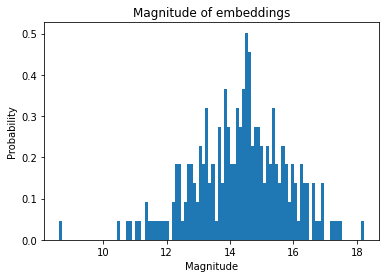

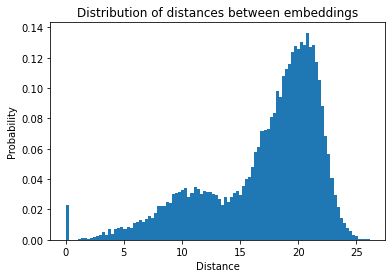

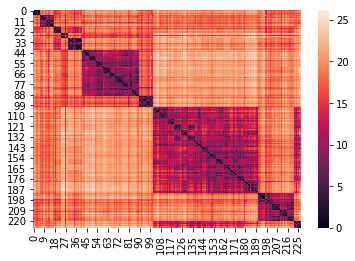

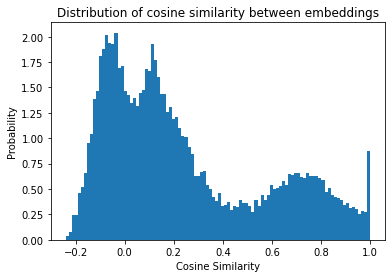

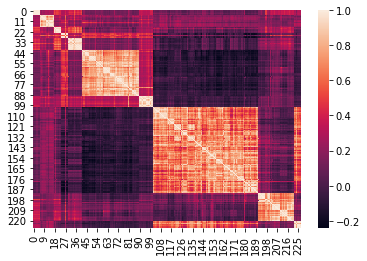

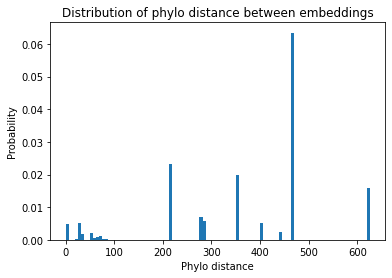

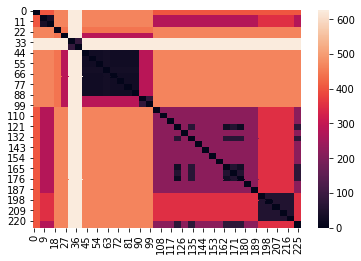

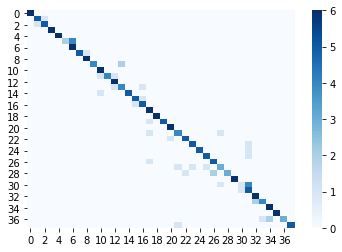

In [43]:

import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp
from sklearn.metrics import confusion_matrix

x = X.reshape(1,-1)
fig = plt.figure(0)
plt.hist(x, bins=100, density=True, label="activations")
# mn, mx = plt.xlim()
# plt.xlim(mn, mx)
# kde = st.gaussian_kde(x)
# print(kde)
# kde_xs = np.linspace(kde, kde, 300)
# plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
# plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Activations")
plt.title("Distribution of values of activations");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'values')))

fig = plt.figure(1)
sqr = torch.sqrt(torch.sum(torch.pow(X, 2), 1).reshape(-1))
plt.hist(sqr, density=True, bins=100, label="magnitude")
plt.ylabel("Probability")
plt.xlabel("Magnitude")
plt.title("Magnitude of embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'magnitudes')))

fig = plt.figure(2)
sqrA = torch.sum(torch.pow(X, 2), 1, keepdim=True).expand(X.shape[0], x.shape[0])
sqrB = torch.sum(torch.pow(X, 2), 1, keepdim=True).expand(X.shape[0], x.shape[0]).t()
ans =  torch.sqrt(sqrA - 2*torch.mm(X, X.t()) + sqrB)
ans2 = ans[torch.triu_indices(ans.shape[0],ans.shape[1])[0], torch.triu_indices(ans.shape[0],ans.shape[1])[1]]
plt.hist(ans2, density=True, bins=100, label="distances")
plt.ylabel("Probability")
plt.xlabel("Distance")
plt.title("Distribution of distances between embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'distances')))

fig = plt.figure(3)
ax = sns.heatmap(ans)
plt.show()
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'distances_heat_map')))

fig = fig = plt.figure(4)
ans = 1 - sp.distance.cdist(X, X, 'cosine')
ans2 = ans[torch.triu_indices(ans.shape[0],ans.shape[1])[0], torch.triu_indices(ans.shape[0],ans.shape[1])[1]]
plt.hist(ans2, density=True, bins=100, label="similarity")
plt.ylabel("Probability")
plt.xlabel("Cosine Similarity")
plt.title("Distribution of cosine similarity between embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'similarity')))

fig = plt.figure(5)
ax = sns.heatmap(ans)
plt.show()
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'similarity_heat_map')))

csv_processor = dataloader.dataset.csv_processor
fig = fig = plt.figure(6)
ans = torch.zeros(len(Y),len(Y))
for indx, i in enumerate(Y):
    for indx2, j in enumerate(Y[indx+1:]):
#         print(csv_processor.getFineList()[i], csv_processor.getFineList()[j],csv_processor.tax.get_distance(csv_processor.getFineList()[i], csv_processor.getFineList()[j]))
        dist = csv_processor.tax.get_distance(csv_processor.getFineList()[i], csv_processor.getFineList()[j])
        ans[indx][indx2+1+indx] = ans[indx2+1+indx][indx] = dist
        
ans2 = ans[torch.triu_indices(ans.shape[0],ans.shape[1])[0], torch.triu_indices(ans.shape[0],ans.shape[1])[1]]
plt.hist(ans2, density=True, bins=100, label="phylo distance")
plt.ylabel("Probability")
plt.xlabel("Phylo distance")
plt.title("Distribution of phylo distance between embeddings");
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'phylo_distance')))

fig = plt.figure(7)
ax = sns.heatmap(ans)
plt.show()
fig.savefig(os.path.join(experimentPathAndName, 'models',trial_hash, "{}_{}_{}.png".format(dataset_name,activation_layer,'phylo_distance_heat_map')))

# fig = plt.figure(8)
# cf_matrix = confusion_matrix(Y, Z)
# ax = sns.heatmap(cf_matrix, cmap='Blues')

In [40]:
len(Z)

232